## Environment setup (Python, virtual environment, dependencies)

Follow these steps once before running the analysis.

1) Install Python 3.10+ (recommended 3.11)

- macOS (Homebrew):
  - Install Homebrew if needed: https://brew.sh
  - Install Python:
```
brew install python@3.11
```
  - Verify:
```
python3 --version
pip3 --version
```
- Windows:
  - Download installer: https://www.python.org/downloads/windows/
  - During install, check "Add python.exe to PATH"
- Linux (Debian/Ubuntu):
```
sudo apt-get update && sudo apt-get install -y python3 python3-pip python3-venv
```

2) Create a virtual environment in this repo directory
```
python3 -m venv .venv
```

3) Activate the virtual environment
- macOS/Linux:
```
source .venv/bin/activate
```
- Windows (PowerShell):
```
.\.venv\Scripts\Activate.ps1
```
- Windows (Command Prompt):
```
.\.venv\Scripts\activate.bat
```

4) Upgrade pip and install dependencies
```
python -m pip install --upgrade pip
pip install -r requirements.txt  # if present
pip install pandas numpy matplotlib seaborn ipykernel
```

5) (Optional) Register this venv as a Jupyter kernel
```
python -m ipykernel install --user --name slack-stats-venv --display-name "Python (slack-stats)"
```

After setup, in VS Code or Jupyter, select the kernel named "Python (slack-stats)" (or your venv) before running the cells below.

# Slack Channel Engagement Analysis

Executive-ready analysis of weekly Slack engagement across channels. This notebook:

- Loads all channel CSVs from `./reports`
- Combines them into a single dataset with a `Channel` column (from file names)
- Produces clear visuals (time series, stacked area, bar charts, scatter, heatmap)
- Summarizes top/bottom performers and overall engagement trend

**Expected CSV columns per file:**
- `Week`, `Week start`
- `Messages`, `Unique senders`, `Reactions`, `Files shared`, `Replies`, `Avg msg length`

## How to run
1. Ensure your CSV exports (one per channel) are located in `./reports` (next to this repo root).
2. File names should be the channel name, e.g. `hlgiu-gse-ai_weeks.csv`.
3. Run the cells below top-to-bottom. All plots and summary tables will be generated.

If you don't have dependencies installed, run:
```
pip install pandas numpy matplotlib seaborn
```

In [49]:
from pathlib import Path
import re
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 1000)

# Plot style configuration for executive readability
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (14, 7)
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.titlepad"] = 14
palette = sns.color_palette("Set2")

# Global configuration: limit timeframe for charts
WEEKS_BACK = 26  # Number of weeks back from today to include

In [50]:
# Load all CSVs from ../reports and combine with Channel column derived from filename
data_dir = Path("../reports")
paths = sorted(data_dir.glob("*.csv"))

if not paths:
  raise FileNotFoundError(
    "No CSV files found in ./reports. Place channel exports like 'channel_weeks.csv' in that folder."
  )

required_cols = {
  "Week", "Week start",
  "Messages", "Unique senders", "Reactions", "Files shared", "Replies", "Avg msg length"
}

# Optional: load channel name mappings (source -> consolidated)
name_map_norm = {}
map_path = data_dir / "name_mappings.txt"
if map_path.exists():
  try:
    map_df = pd.read_csv(map_path, sep="\t", engine="python")
    map_df.columns = [c.strip() for c in map_df.columns]
    src_col = map_df.columns[0]
    tgt_col = map_df.columns[1]
    map_df = map_df[[src_col, tgt_col]].dropna()
    map_df[src_col] = map_df[src_col].astype(str).str.strip()
    map_df[tgt_col] = map_df[tgt_col].astype(str).str.strip()
    map_df = map_df.drop_duplicates(subset=[src_col], keep="last")
    def _norm(s):
      s = str(s).strip()
      s = re.sub(r"^#", "", s)
      return s.lower()
    name_map_norm = { _norm(k): v for k, v in zip(map_df[src_col], map_df[tgt_col]) }
  except Exception as e:
    print(f"Warning: failed to load name mappings: {e}")

frames = []
channels_from_files = []
for p in paths:
  df_i = pd.read_csv(p)
  # Normalize column names (trim only; we keep expected names with spaces)
  df_i.columns = [c.strip() for c in df_i.columns]

  # Validate columns are present (allow extra columns)
  missing = required_cols - set(df_i.columns)
  if missing:
    raise ValueError(f"File {p.name} is missing required columns: {sorted(missing)}")

  # Derive channel name from filename (remove trailing '_weeks'/'-weeks')
  stem = p.stem
  channel = re.sub(r"[_-]?weeks$", "", stem, flags=re.IGNORECASE)
  # Apply consolidated mapping if available (ignore any leading '#' and the '_weeks' suffix handled above)
  norm_key = re.sub(r"^#", "", channel).lower()
  channel_mapped = name_map_norm.get(norm_key, channel)
  df_i["Channel"] = channel_mapped
  channels_from_files.append(channel_mapped)

  # Parse date; coerce to NaT if invalid
  df_i = df_i.rename(columns={"Week start": "WeekStart"})
  df_i["WeekStart"] = pd.to_datetime(df_i["WeekStart"], errors="coerce")

  # Clean numeric columns (remove commas, coerce to numeric)
  num_cols = [
    "Messages", "Unique senders", "Reactions", "Files shared", "Replies", "Avg msg length"
  ]
  for c in num_cols:
    df_i[c] = (
      df_i[c]
      .astype(str)
      .str.replace(",", "", regex=False)
      .str.strip()
    )
    df_i[c] = pd.to_numeric(df_i[c], errors="coerce")
  df_i[num_cols] = df_i[num_cols].fillna(0)

  frames.append(df_i)

# Combine
df = pd.concat(frames, ignore_index=True)
df = df.dropna(subset=["WeekStart"]).copy()

# Filter to last WEEKS_BACK weeks from today
cutoff = pd.Timestamp.today().normalize() - pd.Timedelta(weeks=WEEKS_BACK)
df = df[df["WeekStart"] >= cutoff].copy()

# Sort for determinism
df = df.sort_values(["WeekStart", "Channel"]).reset_index(drop=True)

# Build a complete grid of all weeks x all channels so missing weeks show as 0
# 1) Determine weekly anchor (weekday) from data
weekday_anchor = int(df["WeekStart"].dt.weekday.mode().iloc[0]) if len(df) else 0  # Monday=0
anchor_map = {0: "W-MON", 1: "W-TUE", 2: "W-WED", 3: "W-THU", 4: "W-FRI", 5: "W-SAT", 6: "W-SUN"}
freq = anchor_map.get(weekday_anchor, "W-MON")

# 2) Create range of all week starts over the analysis window
start = df["WeekStart"].min().normalize()
end = df["WeekStart"].max().normalize()
all_weeks = pd.date_range(start=start, end=end, freq=freq)
all_channels = sorted(set(channels_from_files))

# 3) Reindex to full MultiIndex and fill numeric metrics with 0
full_idx = pd.MultiIndex.from_product([all_weeks, all_channels], names=["WeekStart", "Channel"])
df = df.set_index(["WeekStart", "Channel"]).reindex(full_idx)

# Fill the base numeric columns with 0; other columns are not needed beyond these
base_num_cols = ["Messages", "Unique senders", "Reactions", "Files shared", "Replies", "Avg msg length"]
for col in base_num_cols:
  if col not in df.columns:
    df[col] = 0
  df[col] = df[col].fillna(0)

df = df.reset_index()

# Derived metrics (computed after fill so 0-weeks propagate cleanly)
df["Engagement"] = df["Messages"].fillna(0) + df["Reactions"].fillna(0) + df["Replies"].fillna(0)
df["EngagementPerMessage"] = np.where(
  df["Messages"] > 0,
  (df["Reactions"] + df["Replies"]) / df["Messages"],
  0.0,
)
df["ReactionsPerMessage"] = np.where(
  df["Messages"] > 0,
  df["Reactions"] / df["Messages"],
  0.0,
)
df["WeekLabel"] = pd.to_datetime(df["WeekStart"]).dt.strftime("%Y-%m-%d")
df = df.sort_values(["WeekStart", "Channel"]).reset_index(drop=True)

channels = sorted(df["Channel"].unique())
date_min = df["WeekStart"].min()
date_max = df["WeekStart"].max()
print(f"Loaded {len(paths)} files for {len(channels)} channels.")
print(f"Date range: {date_min.date()} to {date_max.date()}")
df.head(3)

Loaded 16 files for 16 channels.
Date range: 2025-04-28 to 2025-09-22


,WeekStart,Channel,Week,Messages,Unique senders,Reactions,Files shared,Replies,Avg msg length,Engagement,EngagementPerMessage,ReactionsPerMessage,WeekLabel
0,2025-04-28,"CSM (Anja, Jim)",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-04-28
1,2025-04-28,"Cloud Ops (Phanee, Sravan)",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-04-28
2,2025-04-28,"Consulting (Justin, Radha, Nik)",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-04-28


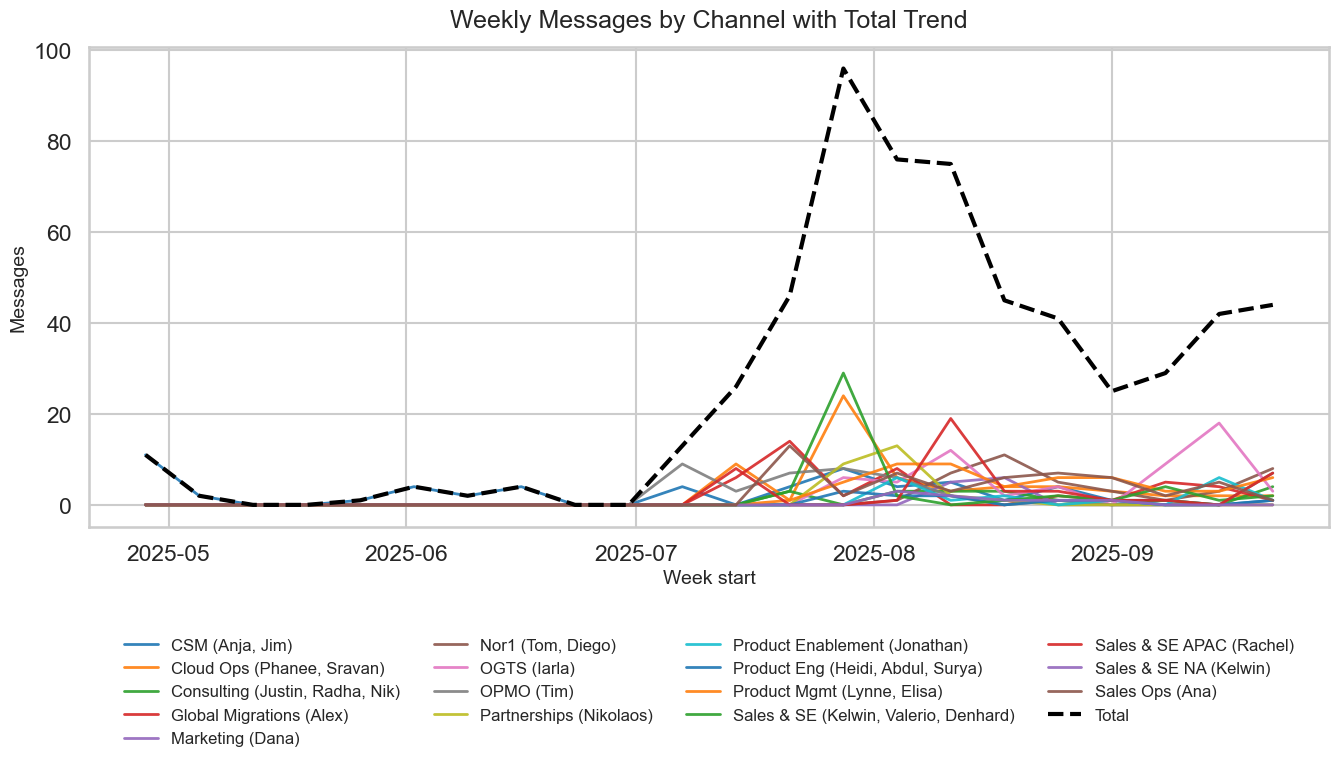

In [51]:
## Time series: Messages per week (by channel) with total combined trend
msgs_pivot = (
  df.pivot_table(
    index="WeekStart", columns="Channel", values="Messages", aggfunc="sum"
  ).fillna(0)
)
total_msgs = msgs_pivot.sum(axis=1).rename("Total")

fig, ax = plt.subplots(figsize=(16, 8))
colors = sns.color_palette("tab10", n_colors=len(msgs_pivot.columns))
for (ch, color) in zip(msgs_pivot.columns, colors):
  ax.plot(msgs_pivot.index, msgs_pivot[ch], label=ch, lw=2, alpha=0.9, color=color)

ax.plot(total_msgs.index, total_msgs.values, label="Total", lw=3, color="black", linestyle="--")
ax.set_title("Weekly Messages by Channel with Total Trend")
ax.set_xlabel("Week start")
ax.set_ylabel("Messages")
ax.legend(ncol=min(4, len(msgs_pivot.columns) + 1), loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=False)
plt.subplots_adjust(bottom=0.28)
plt.show()

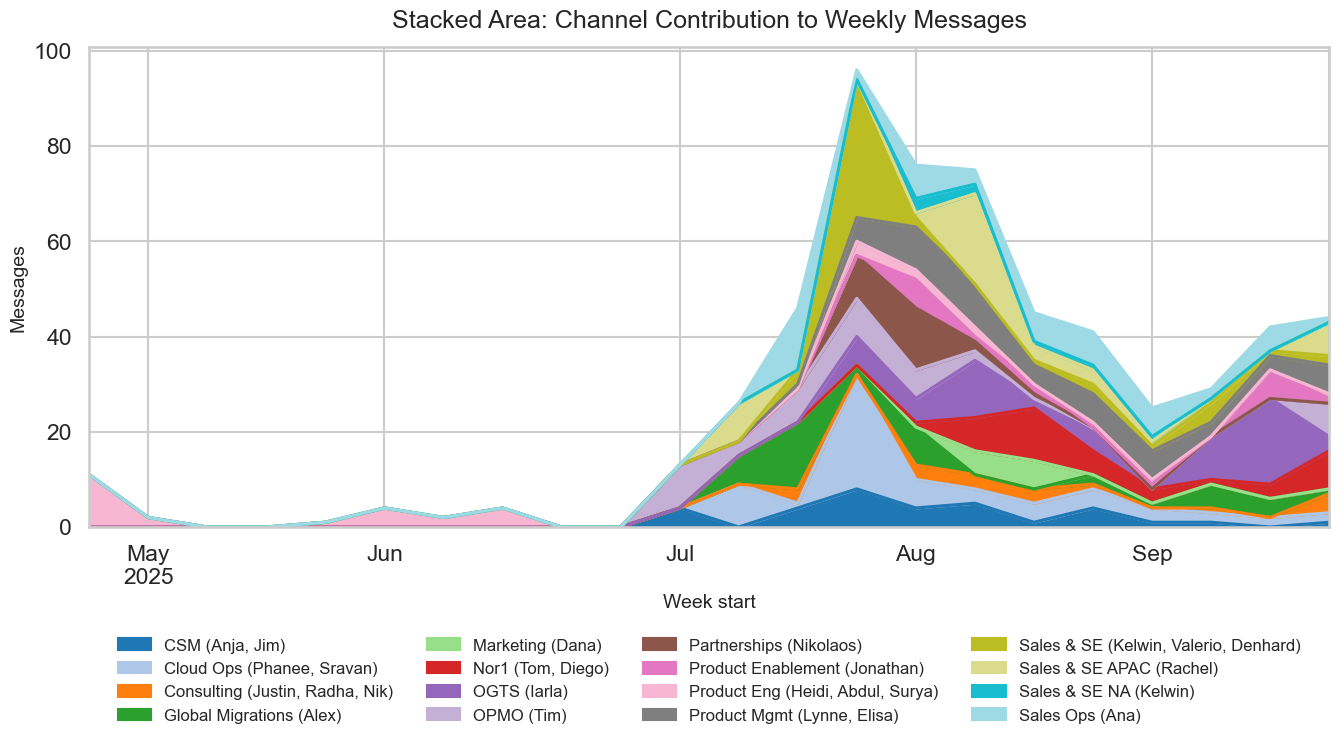

In [52]:
## Stacked area: Contribution of each channel to total weekly messages
fig, ax = plt.subplots(figsize=(16, 8))
msgs_pivot.plot.area(ax=ax, cmap="tab20")
ax.set_title("Stacked Area: Channel Contribution to Weekly Messages")
ax.set_xlabel("Week start")
ax.set_ylabel("Messages")
ax.legend(ncol=min(4, len(msgs_pivot.columns)), loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=False)
plt.subplots_adjust(bottom=0.28)
plt.show()

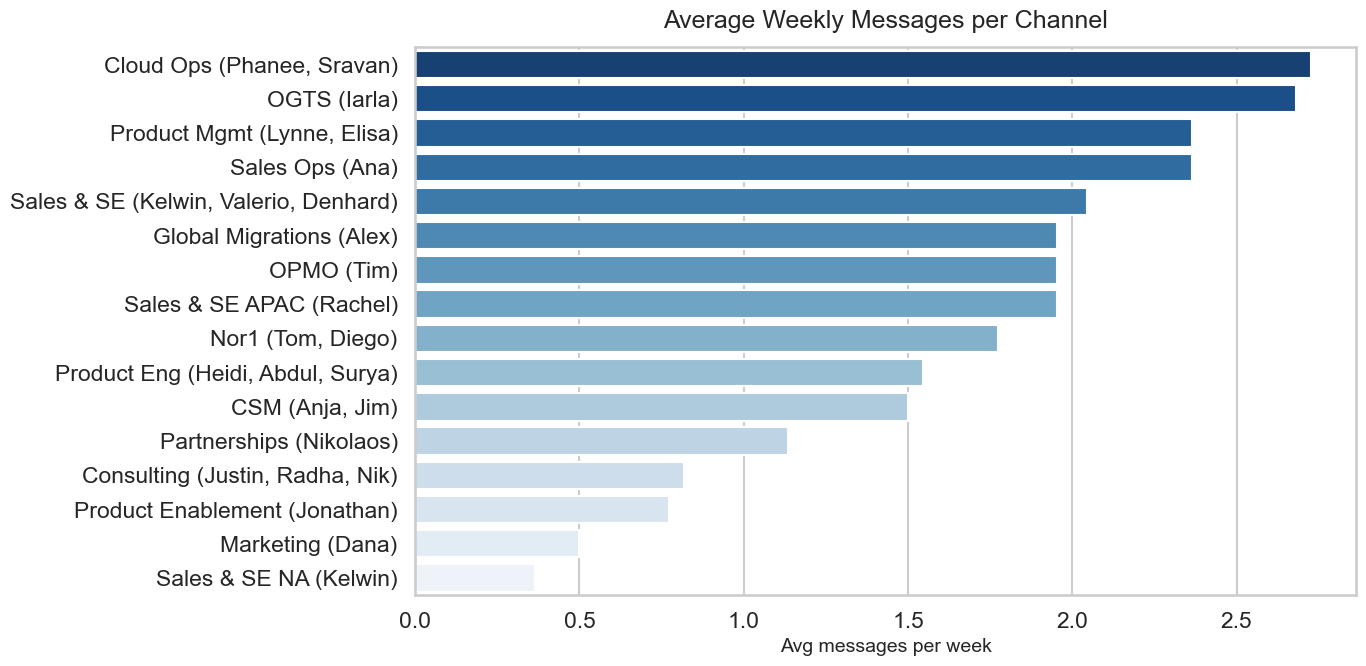

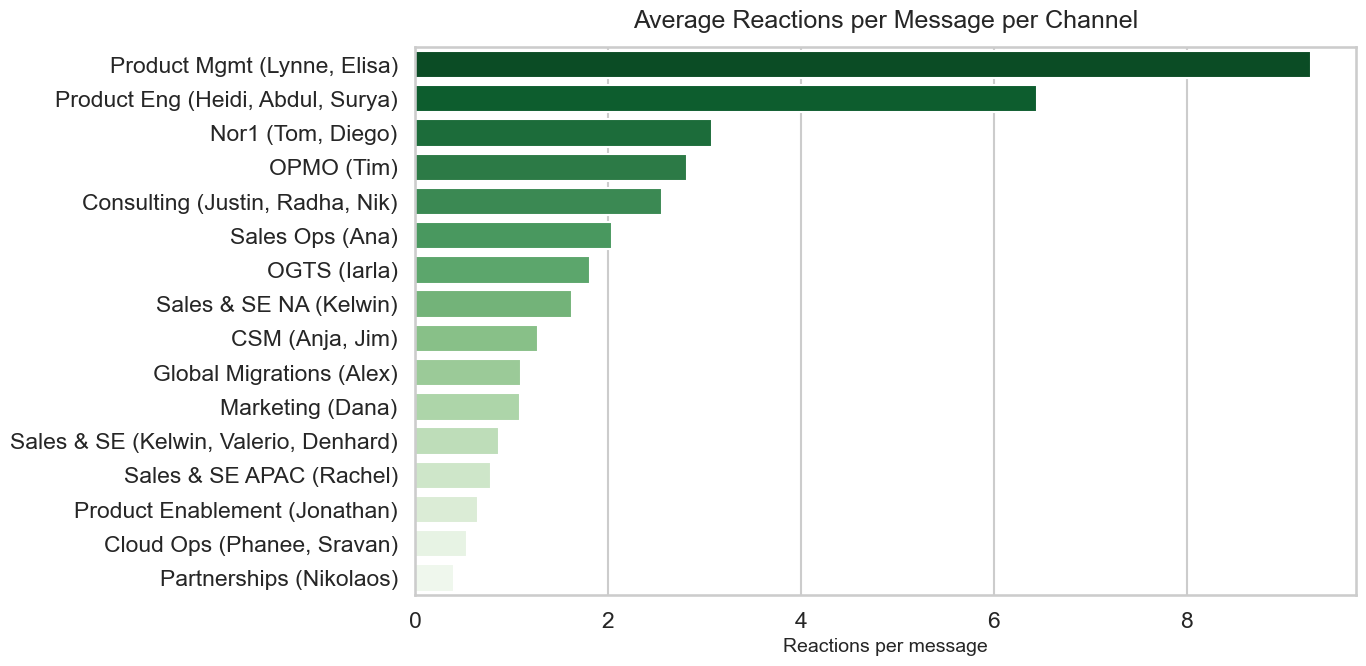

,Channel,avg_weekly_messages,total_messages,total_reactions,total_replies,avg_unique_senders,reactions_per_msg
0,"CSM (Anja, Jim)",1.500000,33.0,42.0,16.0,0.863636,1.272727
1,"Cloud Ops (Phanee, Sravan)",2.727273,60.0,32.0,35.0,1.227273,0.533333
2,"Consulting (Justin, Radha, Nik)",0.818182,18.0,46.0,4.0,0.590909,2.555556
3,Global Migrations (Alex),1.954545,43.0,47.0,14.0,0.909091,1.093023
4,Marketing (Dana),0.500000,11.0,12.0,6.0,0.454545,1.090909


In [53]:
## Bar charts: Average weekly messages per channel; Average reactions per message per channel
agg_per_channel = df.groupby("Channel").agg(
  avg_weekly_messages=("Messages", "mean"),
  total_messages=("Messages", "sum"),
  total_reactions=("Reactions", "sum"),
  total_replies=("Replies", "sum"),
  avg_unique_senders=("Unique senders", "mean")
).reset_index()

agg_per_channel["reactions_per_msg"] = np.where(
  agg_per_channel["total_messages"] > 0,
  agg_per_channel["total_reactions"] / agg_per_channel["total_messages"],
  0.0,
)

# Average weekly messages per channel (sorted)
order_msgs = agg_per_channel.sort_values("avg_weekly_messages", ascending=False)
fig, ax = plt.subplots()
sns.barplot(
  data=order_msgs,
  x="avg_weekly_messages",
  y="Channel",
  palette="Blues_r",
  ax=ax,
)
ax.set_title("Average Weekly Messages per Channel")
ax.set_xlabel("Avg messages per week")
ax.set_ylabel("")
plt.tight_layout()
plt.show()

# Average reactions per message per channel (using totals ratio for robustness)
order_react = agg_per_channel.sort_values("reactions_per_msg", ascending=False)
fig, ax = plt.subplots()
sns.barplot(
  data=order_react,
  x="reactions_per_msg",
  y="Channel",
  palette="Greens_r",
  ax=ax,
)
ax.set_title("Average Reactions per Message per Channel")
ax.set_xlabel("Reactions per message")
ax.set_ylabel("")
plt.tight_layout()
plt.show()

agg_per_channel.head()

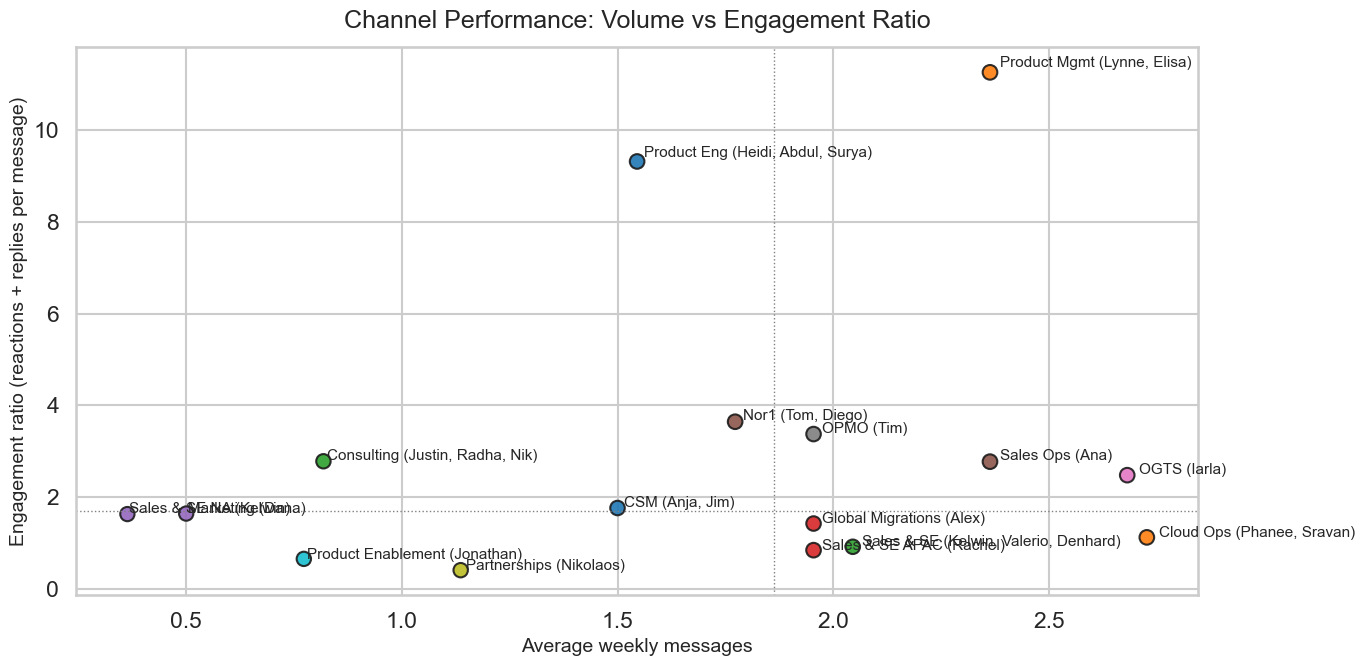

,Channel,total_messages,total_reactions,total_replies,avg_unique_senders,avg_weekly_messages,engagement_ratio
11,"Product Mgmt (Lynne, Elisa)",52.0,483.0,103.0,1.318182,2.363636,11.269231
10,"Product Eng (Heidi, Abdul, Surya)",34.0,219.0,98.0,1.181818,1.545455,9.323529
5,"Nor1 (Tom, Diego)",39.0,120.0,22.0,1.181818,1.772727,3.641026
7,OPMO (Tim),43.0,121.0,24.0,1.000000,1.954545,3.372093
2,"Consulting (Justin, Radha, Nik)",18.0,46.0,4.0,0.590909,0.818182,2.777778


In [55]:
## Scatter: Messages vs engagement ratio (reactions + replies per message) per channel
# Compute engagement ratio per channel using totals
totals = df.groupby("Channel").agg(
  total_messages=("Messages", "sum"),
  total_reactions=("Reactions", "sum"),
  total_replies=("Replies", "sum"),
  avg_unique_senders=("Unique senders", "mean"),
  avg_weekly_messages=("Messages", "mean")
).reset_index()

totals["engagement_ratio"] = np.where(
  totals["total_messages"] > 0,
  (totals["total_reactions"] + totals["total_replies"]) / totals["total_messages"],
  0.0,
)

fig, ax = plt.subplots()
sizes = 100 + 10 * np.sqrt(np.maximum(totals["avg_unique_senders"], 0))  # scale by participation
scatter = ax.scatter(
  totals["avg_weekly_messages"],
  totals["engagement_ratio"],
  s=sizes,
  c=sns.color_palette("tab10", n_colors=len(totals))[0:len(totals)],
  alpha=0.9,
  edgecolors="k"
)

# Label points with channel names
for _, r in totals.iterrows():
  ax.text(r["avg_weekly_messages"] * 1.01, r["engagement_ratio"] * 1.01, r["Channel"], fontsize=11)

# Add median reference lines
x_med = totals["avg_weekly_messages"].median()
y_med = totals["engagement_ratio"].median()
ax.axvline(x_med, color="gray", linestyle=":", lw=1)
ax.axhline(y_med, color="gray", linestyle=":", lw=1)

ax.set_title("Channel Performance: Volume vs Engagement Ratio")
ax.set_xlabel("Average weekly messages")
ax.set_ylabel("Engagement ratio (reactions + replies per message)")
plt.tight_layout()
plt.show()

totals.sort_values("engagement_ratio", ascending=False).head()

In [ ]:
## Heatmap: Channels vs weeks (intensity by number of messages)
heat = df.pivot_table(
  index="Channel",
  columns="WeekStart",
  values="Messages",
  aggfunc="sum"
).fillna(0)
heat = heat.reindex(sorted(heat.columns), axis=1)

fig, ax = plt.subplots(figsize=(max(14, len(heat.columns) * 0.5), 0.6 * len(heat.index) + 3))
sns.heatmap(
  heat,
  cmap="YlGnBu",
  cbar_kws={"label": "Messages"},
  ax=ax
)
ax.set_title("Weekly Message Intensity by Channel")
ax.set_xlabel("Week start")
ax.set_ylabel("Channel")
ax.set_xticklabels([c.strftime("%Y-%m-%d") for c in heat.columns], rotation=45, ha="right")
plt.tight_layout()
plt.show()

heat.head(3)

In [ ]:
## Summary statistics
# Top 3 channels by total engagement (messages + reactions + replies)
eng_by_channel = df.groupby("Channel").agg(
  total_messages=("Messages", "sum"),
  total_reactions=("Reactions", "sum"),
  total_replies=("Replies", "sum"),
  total_engagement=("Engagement", "sum"),
  avg_unique_senders=("Unique senders", "mean")
).reset_index()

eng_by_channel["engagement_ratio"] = np.where(
  eng_by_channel["total_messages"] > 0,
  (eng_by_channel["total_reactions"] + eng_by_channel["total_replies"]) / eng_by_channel["total_messages"],
  0.0,
)

top3_engagement = eng_by_channel.sort_values("total_engagement", ascending=False).head(3)
print("Top 3 channels by total engagement:")
display(top3_engagement[["Channel", "total_engagement", "total_messages", "total_reactions", "total_replies"]])

# Channels with highest average participation (unique senders)
top_participation = eng_by_channel.sort_values("avg_unique_senders", ascending=False)
print("\nChannels with highest average participation (unique senders):")
display(top_participation[["Channel", "avg_unique_senders"]].head(10))

# Bottom 3 channels by engagement ratio
bottom3_ratio = eng_by_channel.sort_values("engagement_ratio").head(3)
print("\nBottom 3 channels by engagement ratio (reactions + replies per message):")
display(bottom3_ratio[["Channel", "engagement_ratio", "total_messages"]])

# Overall engagement growth trend
weekly_engagement = df.groupby("WeekStart")["Engagement"].sum().sort_index()

# Smoothing via 4-week rolling average for clearer executive view
roll = weekly_engagement.rolling(4, min_periods=1).mean()
start_avg = roll.iloc[:min(4, len(roll))].mean() if len(roll) else 0
end_avg = roll.iloc[-min(4, len(roll)):].mean() if len(roll) else 0
if start_avg == 0:
  pct_change = np.nan
else:
  pct_change = (end_avg - start_avg) / start_avg * 100.0

# Linear trend slope (messages per week) using ordinal time
if len(weekly_engagement) >= 2:
  x = (weekly_engagement.index - weekly_engagement.index.min()).days.values
  y = weekly_engagement.values
  slope = np.polyfit(x, y, 1)[0]
else:
  slope = np.nan

print("\nOverall engagement growth trend:")
if np.isnan(pct_change):
  print("Insufficient baseline to compute percent change.")
else:
  print(f"Rolling 4-week average change: {pct_change:,.1f}% from start to end of period.")
if np.isnan(slope):
  print("Insufficient data to compute linear trend slope.")
else:
  print(f"Estimated linear slope: {slope:,.1f} engagement units per week.")

# Optional: plot the smoothed overall engagement trend
fig, ax = plt.subplots()
ax.plot(weekly_engagement.index, weekly_engagement.values, label="Weekly engagement", alpha=0.5)
ax.plot(roll.index, roll.values, label="4-wk rolling avg", lw=3, color="black")
ax.set_title("Overall Weekly Engagement (Smoothed)")
ax.set_xlabel("Week start")
ax.set_ylabel("Engagement (messages + reactions + replies)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=False, ncol=2)
plt.subplots_adjust(bottom=0.28)
plt.show()

### Notes
- Engagement ratio = (Reactions + Replies) / Messages.
- "Average reactions per message" is computed using totals per channel to avoid small-sample bias.
- Scatter point size scales with average unique senders (participation). Larger bubbles = more participants.
- All visuals are designed for clarity with executive audiences: concise titles, readable labels, and legends.
- Zero-filled weeks: The dataset is reindexed to the full grid of weeks × channels so weeks with no activity still appear as 0, making lack of engagement visible.